In [35]:
import pandas_datareader as pdr

In [36]:
df = pdr.get_data_tiingo('AAPL', api_key='516e74d2390f1c16ff7d969a60bd7999d8b81d5e')

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [37]:
df.to_csv('data/data_stockpriceforcast_LSTM/AAPL.csv')

In [38]:
import pandas as pd

In [39]:
df = pd.read_csv('data/data_stockpriceforcast_LSTM/AAPL.csv')

In [40]:
df.shape

(1259, 14)

In [41]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2018-12-24 00:00:00+00:00,146.83,151.55,146.59,148.15,37169232,35.231152,36.363693,35.173565,35.547879,148676928,0.0,1.0
1,AAPL,2018-12-26 00:00:00+00:00,157.17,157.23,146.72,148.30,58582544,37.712185,37.726581,35.204758,35.583871,234330176,0.0,1.0
2,AAPL,2018-12-27 00:00:00+00:00,156.15,156.77,150.07,155.84,53117065,37.467441,37.616207,36.008574,37.393058,212468260,0.0,1.0
3,AAPL,2018-12-28 00:00:00+00:00,156.23,158.52,154.55,157.50,42291424,37.486636,38.036111,37.083528,37.791367,169165696,0.0,1.0
4,AAPL,2018-12-31 00:00:00+00:00,157.74,159.36,156.48,158.53,35003466,37.848954,38.237665,37.546623,38.038510,140013864,0.0,1.0


In [42]:
df1 = df.reset_index()['close']

In [43]:
df1.shape

(1259,)

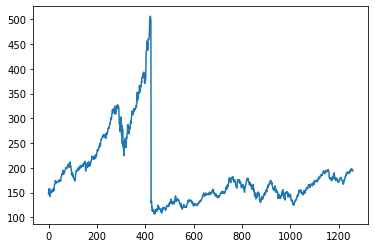

In [44]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [45]:
df1

0       146.83
1       157.17
2       156.15
3       156.23
4       157.74
         ...  
1254    195.89
1255    196.94
1256    194.83
1257    194.68
1258    193.60
Name: close, Length: 1259, dtype: float64

In [46]:
import numpy as np

In [47]:
## LSTM is sensitive to scale of the data. So always scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [48]:
df1.shape

(1259, 1)

In [49]:
print(df1)

[[0.10016281]
 [0.12606137]
 [0.12350657]
 ...
 [0.22038823]
 [0.22001252]
 [0.21730745]]


In [50]:
## split train and test data
train_size = int(len(df1) * 0.65)
test_size = len(df1) - train_size

train_data, test_data = df1[0:train_size,:], df1[train_size:len(df1),:1]

In [51]:
train_size , test_size

(818, 441)

In [52]:
len(train_data), len(test_data)

(818, 441)

In [53]:
import numpy as np
#convert an array of data to dataset matrix
def create_dataset(dataset, time_step=1):
    dataX,dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [54]:
# reshape into X = t,t+1,t+2,t+3 and Y = t+4
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [55]:
print(X_train)

[[0.10016281 0.12606137 0.12350657 ... 0.21059487 0.20849092 0.20578585]
 [0.12606137 0.12350657 0.12370695 ... 0.20849092 0.20578585 0.19098309]
 [0.12350657 0.12370695 0.12748904 ... 0.20578585 0.19098309 0.19977458]
 ...
 [0.10469631 0.1063995  0.10522229 ... 0.1208516  0.13212273 0.13470257]
 [0.1063995  0.10522229 0.11453976 ... 0.13212273 0.13470257 0.14311835]
 [0.10522229 0.11453976 0.10760175 ... 0.13470257 0.14311835 0.14662492]]


In [56]:
X_train.shape, y_train.shape

((717, 100), (717,))

In [57]:
X_test.shape, y_test.shape

((340, 100), (340,))

In [58]:
# reshape input to be [samples,time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
X_train.shape, X_test.shape

((717, 100, 1), (340, 100, 1))

In [31]:
#Create a LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [33]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_square_error', optimizer = 'adam')

In [ ]:
model.summary()

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 100, batch_size=64, verbose = 1)

In [ ]:
import tensorflow as tf

In [34]:
tf.__version__

In [ ]:
## prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
## Calculate RMSE performace matrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

In [ ]:
## Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

In [ ]:
## Plotting
look_back = 100
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: len(df1)-1, :] = test_predict

#plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [60]:
len(test_data)

441

In [62]:
x_input = test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [69]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
print(temp_input)

[0.21122103944896675, 0.1882279273638071, 0.18036318096430803, 0.18274264245460237, 0.1787100814026299, 0.17815904821540385, 0.17770820288040068, 0.18189104571070758, 0.1768566061365059, 0.1746524733876017, 0.16821540388227924, 0.16944270507200998, 0.17282404508453347, 0.17630557294927984, 0.18604884157795865, 0.17417658108954281, 0.17976205385097055, 0.18371947401377575, 0.1935629304946775, 0.20240450845335, 0.20295554164057605, 0.20693800876643703, 0.20753913587977452, 0.19053224796493418, 0.1771321227301189, 0.17868503443957418, 0.18164057608015027, 0.17397620538509706, 0.16874139010644956, 0.17257357545397617, 0.17074514715090788, 0.17815904821540385, 0.18091421415153408, 0.17194740137758296, 0.16804007514088914, 0.17019411396368184, 0.173425172197871, 0.16310582341891044, 0.15927363807138384, 0.15992485911083276, 0.16122730118973072, 0.16758922980588598, 0.16420788979336254, 0.1673638071383844, 0.17049467752035058, 0.17695679398872882, 0.18071383844708827, 0.17921102066374445, 0.1

In [ ]:
# demonstrate prediction for next 30 days

list_output = []
n_steps = 100
i = 0

while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        y_hat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,y_hat))
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        #print(temp_input)
        list_output.extend(y_hat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        y_hat = model.predict(x_input,verbose=0)
        print(y_hat[0])
        temp_input.extend(y_hat[0].tolist())
        print(len(temp_input))
        list_output.extend(y_hat.tolist())
        i = i+1

print(list_output)

In [ ]:
day_new = np.arange(1,101)
day_pred = np.aranae(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

In [ ]:
df3 = df1.tolist()
df3.extend(list_output)

In [ ]:
plt.olot(day_new,scaler.inverse_transform(df1[1159:]))
plt.plot(day_pred,scaler.inverse_transform(list_output))

In [ ]:
df3 = df1.tolist()
df3.extend(list_output)
plt.plot(df3[1200:])